In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib as mpl
mpl.style.use('seaborn-notebook')

/tmp/ipykernel_80136/2941220016.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-notebook')


In [3]:
df = pd.read_csv("../data/tonedata.csv", sep=',')
df

FileNotFoundError: [Errno 2] No such file or directory: '../data/tonedata.csv'

In [3]:
X = df.age.values.astype('d')
Xs = X.reshape(-1,1)
Y = df.score.values.astype('d')

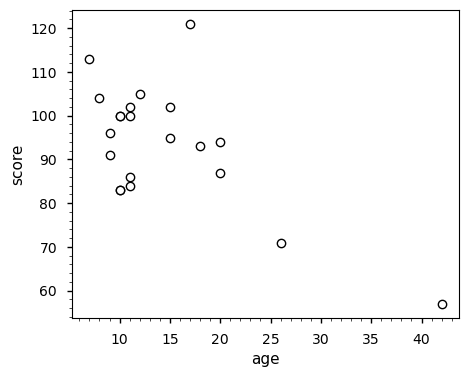

In [4]:
plt.figure(figsize=(5.0, 4.0))
plt.scatter(X, Y, s=36, c='w', edgecolors='k', linewidths=1.)
plt.minorticks_on()
plt.xlabel('age')
plt.ylabel('score')
# plt.savefig('fig/kmean_regression_tonedata.eps')
plt.show()

In [5]:
import mlgrad
import mlgrad.model as ml_model
import mlgrad.risk as ml_risk
import mlgrad.loss as ml_loss
import mlgrad.weights as ml_weights
import mlgrad.func as ml_func
import mlgrad.func2 as ml_func2
import mlgrad.af as ml_af

In [6]:
minloss_sq = ml_loss.SoftMinLoss(ml_loss.SquareErrorLoss(), 3, a=22)
minloss_abs = ml_loss.SoftMinLoss(ml_loss.ErrorLoss(ml_func.SoftAbs(0.01)), 3, a=22)

In [9]:
def make_models():
    layer = ml_model.GeneralModelLayer(1)
    linmod1 = ml_model.LinearModel(1)
    linmod2 = ml_model.LinearModel(1)
    linmod3 = ml_model.LinearModel(1)
    layer.append(linmod1)
    layer.append(linmod2)
    layer.append(linmod3)
    nn = ml_model.FFNetworkModel()
    nn.add(layer)

    nn.allocate()
    nn.init_param()
    
    return nn, linmod1, linmod2, linmod3

def solve(minloss):
    nn, linmod1, linmod2, linmod3 = make_models()
    risk = ml_risk.ERisk2(Xs, Y, nn, minloss)
    alg = mlgrad.erm_fg(risk, n_restart=5, h=0.1, tol=1.0e-9, n_iter=3000)
    return alg, nn, linmod1, linmod2, linmod3 

def rob_solve(minloss, alpha=0.98):
    nn, linmod1, linmod2, linmod3 = make_models()
    risk = ml_risk.ERisk2(Xs, Y, nn, minloss)
    agg_func = ml_af.averaging_function("WM", alpha=alpha, rhofunc=ml_func.Sqrt(0.01))
    weights = ml_weights.MWeights(agg_func, risk)
    _fg = mlgrad.fg(risk, h=0.1, tol=1.0e-9, n_iter=3000)
    alg = mlgrad.erm_irgd(_fg, weights, tol=1.0e-7, n_restart=1, )
    return alg, nn, linmod1, linmod2, linmod3

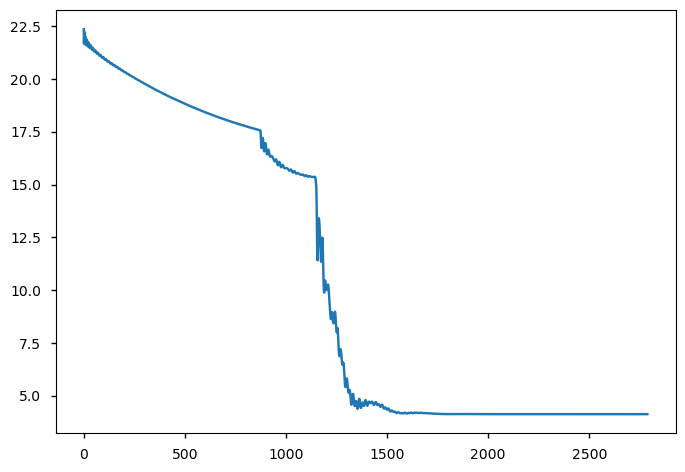

In [43]:
alg_sq, nn, linmod1, linmod2, linmod3 = solve(minloss_sq)

plt.plot(alg_sq.lvals)
plt.show()

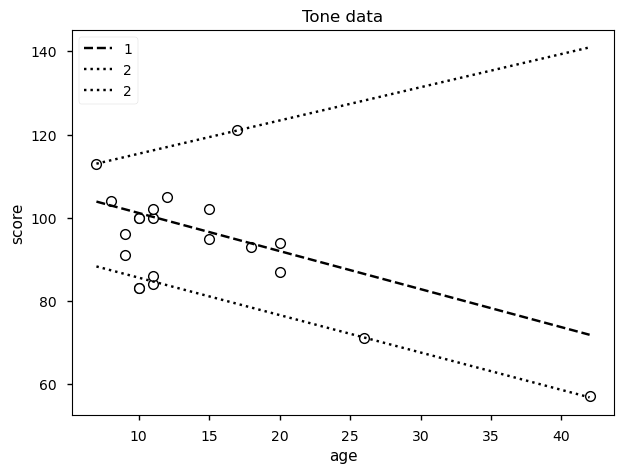

In [44]:
plt.figure(figsize=(7,5))
plt.scatter(X, Y, s=49, c='w', edgecolors='k', linewidth=1.0)
XX = np.array([X.min(), X.max()])
XXs = XX.reshape(-1,1)
plt.title('Tone data')
plt.plot(XX, linmod1.evaluate_all(XXs), linestyle='--', label='1', color='k')
plt.plot(XX, linmod2.evaluate_all(XXs), linestyle=':', label='2', color='k')
plt.plot(XX, linmod3.evaluate_all(XXs), linestyle=':', label='2', color='k')
plt.xlabel('age')
plt.ylabel('score')
plt.legend()
plt.show()

17.775025436069754


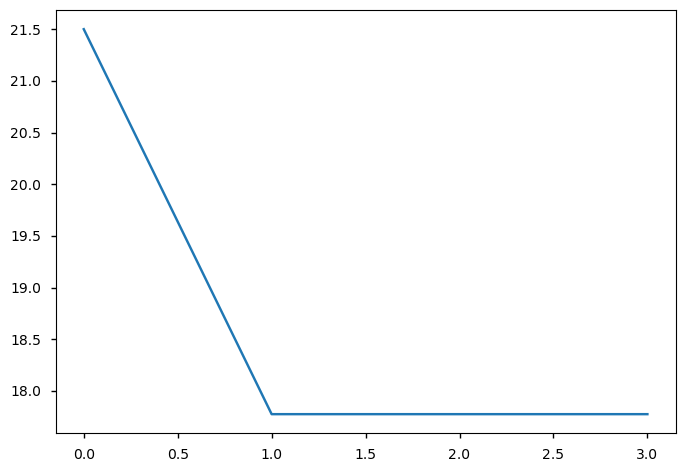

In [48]:
rob_alg, rob_nn, rob_linmod1, rob_linmod2, rob_linmod3 = rob_solve(minloss_sq, 0.96)

plt.plot(rob_alg.lvals)
plt.show()

In [49]:
print(np.array(rob_linmod1.param))
print(np.array(rob_linmod2.param))
print(np.array(rob_linmod3.param))
rob_alg.K

[82.30699321  1.83723531]
[98.89766202 -0.85351015]
[16.24862043 13.82165448]


3

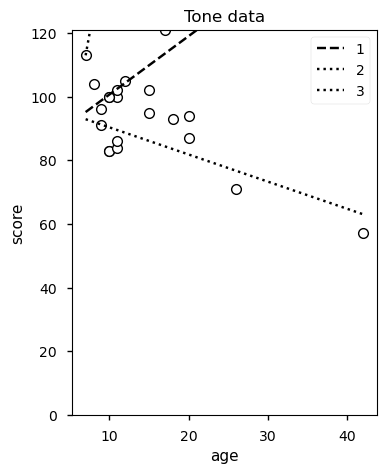

In [50]:
plt.figure(figsize=(7/(16/9),5))
# plt.figure(figsize=(15,12))
plt.scatter(X, Y, s=49, c='w', edgecolors='k', linewidth=1.0)
plt.title("Tone data")
plt.plot(XX, rob_linmod1.evaluate_all(XXs), linestyle='--', label='1', color='k')
plt.plot(XX, rob_linmod2.evaluate_all(XXs), linestyle=':', label='2', color='k')
plt.plot(XX, rob_linmod3.evaluate_all(XXs), linestyle=':', label='3', color='k')
plt.ylim(0, Y.max())
plt.xlabel('age')
plt.ylabel('score')
plt.legend()
# plt.savefig('fig/tonedata_scatter.eps')
plt.show()

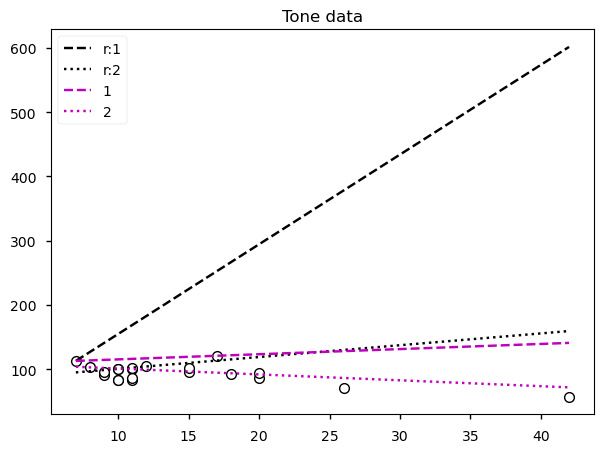

In [41]:
plt.figure(figsize=(7,5))
# plt.figure(figsize=(15,12))
plt.scatter(X, Y, s=49, c='w', edgecolors='k', linewidth=1.0)
plt.title("Tone data")
plt.plot(XX, rob_linmod1.evaluate_all(XXs), linestyle='--', label='r:1', color='k')
plt.plot(XX, rob_linmod2.evaluate_all(XXs), linestyle=':', label='r:2', color='k')
plt.plot(XX, linmod1.evaluate_all(XXs), linestyle='--', label='1', color='m')
plt.plot(XX, linmod2.evaluate_all(XXs), linestyle=':', label='2', color='m')
plt.legend()
# plt.savefig('fig/tonedata_scatter.eps')
plt.show()

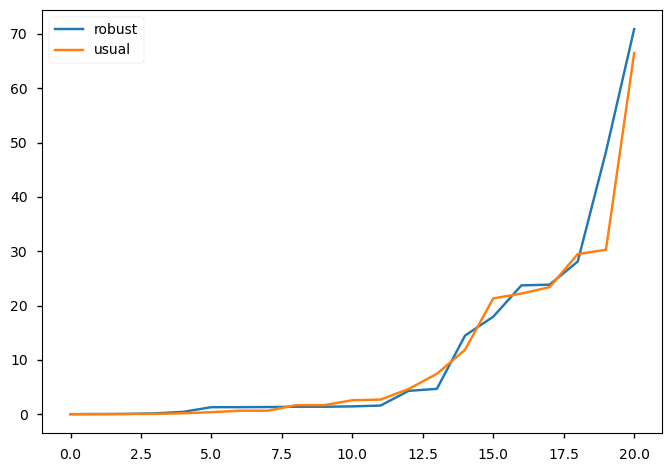

In [14]:
plt.plot(sorted(rob_alg.risk.evaluate_losses()), label='robust')
plt.plot(sorted(alg_sq.risk.evaluate_losses()), label='usual')
plt.legend()
plt.show()

In [15]:
from mlgrad.irgd2 import IRGD2

In [25]:
linmod1 = ml_model.LinearModel(1)
linmod2 = ml_model.LinearModel(1)
soft_min = ml_func2.SoftMin(p=22)
model_comp = ml_model.ModelComposition(soft_min)
model_comp.append(linmod1)
model_comp.append(linmod2)
model_comp.allocate()

In [29]:
avr_func = ml_af.averaging_function("WM", alpha=0.9, rhofunc=ml_func.Sqrt(0.01))
irgd2 = IRGD2(Xs, Y, model_comp, avr_func, ml_loss.SquareErrorLoss())

4352.261904756755


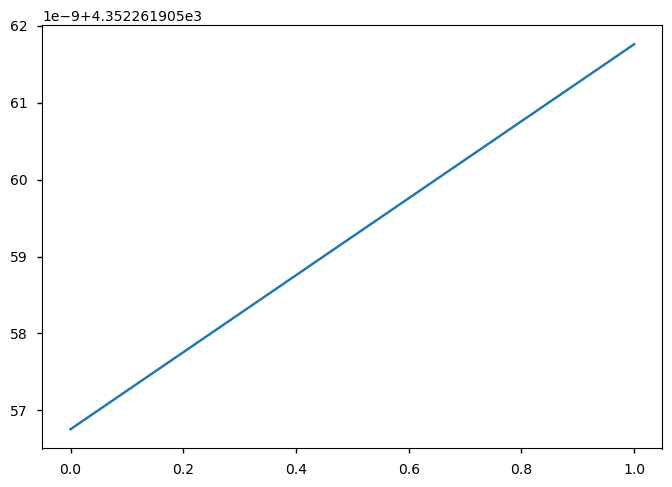

In [30]:
irgd2.fit()

plt.plot(irgd2.lvals)
plt.show()

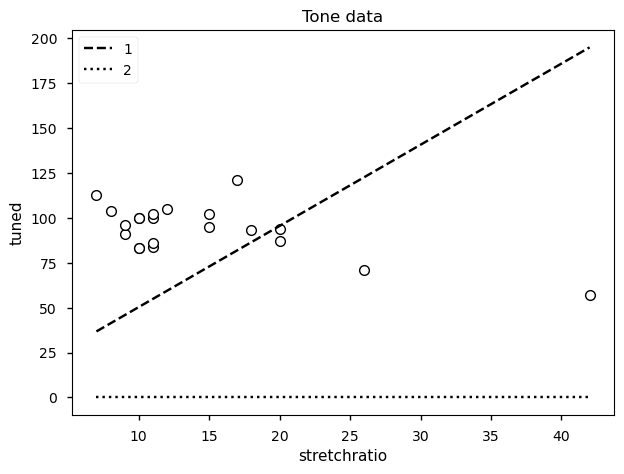

In [31]:
plt.figure(figsize=(7,5))
plt.scatter(X, Y, s=49, c='w', edgecolors='k', linewidth=1.0)
XX = np.array([X.min(), X.max()])
XXs = XX.reshape(-1,1)
plt.title('Tone data')
plt.plot(XX, linmod1.evaluate_all(XXs), linestyle='--', label='1', color='k')
plt.plot(XX, linmod2.evaluate_all(XXs), linestyle=':', label='2', color='k')
plt.xlabel('stretchratio')
plt.ylabel('tuned')
plt.legend()
plt.show()